# Setup

In [2]:
from pathlib import Path

import boto3
import numpy
import pandas

import solver
from utils.io.s3 import download_dataframe, list_objects
from utils.validation.viz import ItemInfo, RecommendedItemInfo, show_recs_for_item

In [3]:
s3_session = boto3.session.Session()
s3_client = s3_session.client(service_name='s3', endpoint_url='https://storage.yandexcloud.net')

In [7]:
train_df = download_dataframe(s3_client, solver.s3_bucket, solver.data_path / 'imdb_movies.parquet')
valid_df = download_dataframe(s3_client, solver.s3_bucket, solver.data_path / 'relevant_titles_subsample.parquet')

# Browse data

In [29]:
train_df.head()

,title_id,poster_url,type,name,original_name,description,genre,date,rating_count,rating_value,keywords,featured_review,stars,directors,creators
0,tt0111161,https://m.media-amazon.com/images/M/MV5BNDE3OD...,Movie,Побег из Шоушенка,The Shawshank Redemption,"Over the course of several years, two convicts...",[Drama],1994-10-14,2755277.0,9.3,"[prison, based on the works of stephen king, e...",It is no wonder that the film has such a high ...,"[Tim Robbins, Morgan Freeman, Bob Gunton]",[Frank Darabont],"[Stephen King, Frank Darabont]"
1,tt0068646,https://m.media-amazon.com/images/M/MV5BM2MyNj...,Movie,Крестный отец,The Godfather,"Don Vito Corleone, head of a mafia family, dec...","[Crime, Drama]",1972-03-24,1917037.0,9.2,"[mafia, patriarch, crime family, organized cri...",I love this movie and all of the GF movies. I ...,"[Marlon Brando, Al Pacino, James Caan]",[Francis Ford Coppola],"[Mario Puzo, Francis Ford Coppola]"
2,tt0468569,https://m.media-amazon.com/images/M/MV5BMTMxNT...,Movie,Тёмный рыцарь,The Dark Knight,When the menace known as the Joker wreaks havo...,"[Action, Crime, Drama]",2008-08-14,2728169.0,9.0,"[dc comics, psychopath, moral dilemma, superhe...","If someone else acted as Joker, I would give t...","[Christian Bale, Heath Ledger, Aaron Eckhart]",[Christopher Nolan],"[Jonathan Nolan, Christopher Nolan, David S. G..."
3,tt0050083,https://m.media-amazon.com/images/M/MV5BMWU4N2...,Movie,12 разгневанных мужчин,12 Angry Men,The jury in a New York City murder trial is fr...,"[Crime, Drama]",1961-11-13,816234.0,9.0,"[jury, dialogue driven, courtroom, trial, jury...",&apos;12 Angry Men&apos; is an outstanding fil...,"[Henry Fonda, Lee J. Cobb, Martin Balsam]",[Sidney Lumet],[Reginald Rose]
4,tt0071562,https://m.media-amazon.com/images/M/MV5BMWMwMG...,Movie,Крестный отец 2,The Godfather Part II,The early life and career of Vito Corleone in ...,"[Crime, Drama]",1974-12-18,1305122.0,9.0,"[revenge, 1950s, corrupt politician, cuban rev...",The original Godfather is a brilliant work. It...,"[Al Pacino, Robert De Niro, Robert Duvall]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]"


In [38]:
train_df['directors'].isna().sum()

0

# Show recommendations

In [9]:
pipeline_id = 'similarity'

In [34]:
list_objects(s3_client, solver.s3_bucket, solver.submission_path / pipeline_id)

['hardml/recsys/lesson2/submissions/similarity/20240206T064200.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240206T064930.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T181905.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T182935.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T190422.parquet',
 'hardml/recsys/lesson2/submissions/similarity/20240207T191302.parquet']

In [39]:
submission_df = download_dataframe(s3_client,
                                   solver.s3_bucket,
                                   solver.submission_path / pipeline_id / '20240207T192302.parquet')
submission_df.head()

,title_id,recs
0,tt0111161,"[tt0120689, tt0884328, tt0100157, tt0080474, t..."
1,tt0068646,"[tt0071562, tt0099674, tt7661390, tt0086216, t..."
2,tt0468569,"[tt0372784, tt1345836, tt0482571, tt3322312, t..."
3,tt0050083,"[tt0050051, tt1872194, tt7949212, tt0051201, t..."
4,tt0071562,"[tt0068646, tt0099674, tt0113277, tt0086216, t..."


In [32]:
base_item_id = 'tt0468569'

In [24]:
movies = train_df.set_index(solver.title_id_column).to_dict(orient='index')
len(movies)

9798

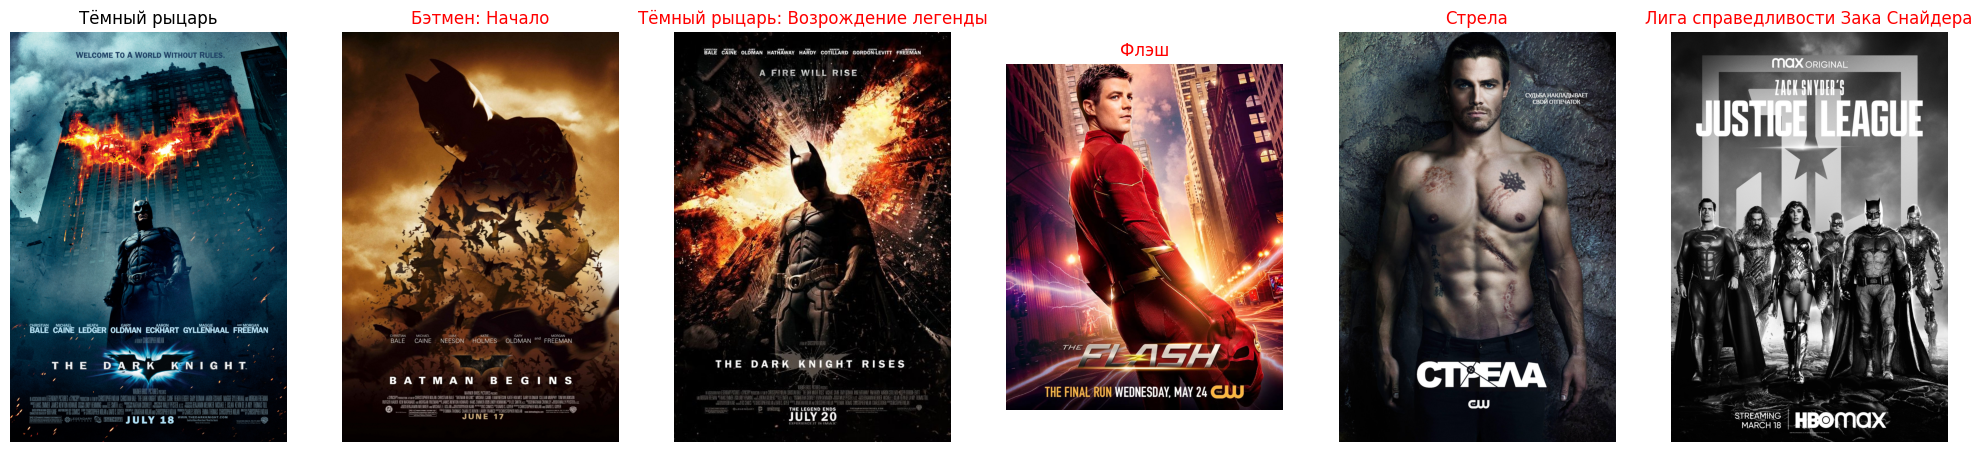

In [36]:
item_info = ItemInfo(name=movies[base_item_id]['name'],
                     image_url=movies[base_item_id]['poster_url'])

preds_rows = submission_df.set_index(solver.title_id_column).loc[base_item_id, solver.recs_column]
recs_info = [RecommendedItemInfo(name=movies[title_id]['name'],
                                 image_url=movies[title_id]['poster_url'],
                                 in_y_true=False)
             for title_id in preds_rows[:5]]

show_recs_for_item(item_info, recs_info);